### 課題2
サンプル画像を各自，自分で用意した画像に入れ替えて，以下の小問の(1)-(2)を解答すること．(3)は任意提出の発展課題とする．

1. OptimizerをRMSprop, Adamに変更して，モーメンタムSDGとの違いを観察せよ．
1. (1)で最もlossが小さくなったoptimizerを利用して，Batch Normalization Layer を入れた場合と入れない場合で，結果を比較せよ．
1. 複数の画像に対応させてみよ．学習画像を2枚, 3枚とするとどうなるか？

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# カレントディレクトリの読み込みとカレントディレクトリへの移動
import sys
sys.path.append(f'/content/drive/My Drive/system/')
import os
os.chdir(f'/content/drive/My Drive/system/myanswer')

In [ ]:
import numpy as np
import math
import time

import keras
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization

In [ ]:
from skimage import feature,filters
from PIL import Image
import os
import sys

%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
import keras

In [ ]:
def convert_image_to_matrix(img_path, method="canny"):
    """
    入力画像を配列化しエッジを抽出した画像を配列化
    グレースケール化した画像を配列化する関数
    
    入力
    img_path(str): 画像のファイルパス
    method: エッジ抽出の方法 cannyかsobelを想定
    
    出力
    img: 配列化した画像
    edge: エッジ抽出した画像
    gray: グレースケール化した画像
    """
    img_org = Image.open(img_path).resize((320,240))
    img = np.array(img_org, dtype=np.uint8)
    gray = np.array(img_org.convert('L'), dtype=np.uint8)
    if method == "canny":
        edge = feature.canny(gray,sigma=2)  # Canny でエッジ抽出
        edge = edge * 255
        return img, edge, gray
    elif method == "sobel":
        edge = filters.sobel(gray) # Sobel でエッジ抽出
        edge = edge * 255
        return img, edge, gray
    else:
        raise ValueError("Invalid edge extraction method")

In [ ]:
# エッジ検出フィルタ，グレースケール化フィルタの切り替え
def show_image(img, edge, gray, use_edge=True):
    """
    画像を行列に変換
    入力 
    img:入力画像
    edge: エッジ抽出した画像
    gray: グレースケール化した画像
    use_edge(bool): エッジ化した画像を使うかどうか
    
    出力
    use_edge が Trueの場合
    エッジ抽出した画像
    
    use_edge が Falseの場合
    グレースケール画像

    """
    if use_edge:
        gt = edge
    else:
        gt = gray

    plt.subplot(121)
    plt.axis("off")
    plt.imshow(img)
    plt.subplot(122)
    plt.axis("off")
    plt.imshow(gt,plt.cm.gray)
    
    return gt

In [ ]:
def convert_pixel_value(img, gt):
    """
    画素値が [-1,1) の範囲の値になるように変換する関数
    入力
    img: RGBの画像
    gt: エッジ抽出した画像 or グレースケール画像
    
    出力
    input: [-1,1) の範囲の値になるように変換したRGB画像
    output: [-1,1) の範囲の値になるように変換した グレースケール 
            or 
            [-1,1) の範囲の値になるように変換したエッジ抽出をした画像
    """
    # Keras は (h,w,c)が標準ですので，前回の
    #input  = (np.asarray(img, dtype=np.float32).transpose(2,0,1)-128)/128.0 の transposeが不要になります．
    input  = (np.asarray(img, dtype=np.float32)-127.5)/127.5
    output = (np.asarray(gt, dtype=np.float32)-127.5)/127.5

    # Keras では，convolution へ与えるデータは最初にbatchの次元を追加して４次元テンソルで表現します．
    # 画像１枚での学習なので，batch は 1 です．
    input = input[np.newaxis, ...]               # (240,320,3) -> (1,240,320,3)
    output = output[np.newaxis, ..., np.newaxis] # (230,320) -> (1,240,320,1)
    
    return input, output

In [ ]:
# callback のクラス ShowGraphを定義
# グラフ表示で必要なので，コンストラクタで，model, 最大エポック数 を受け取っておく．
# model は，学習途中のパラメータを用いて， y=f(x)を描画するのに必要．
class ShowGraph(keras.callbacks.Callback):
    def __init__(self,model,max_epoch,test_img, optimizer, is_batch):
        # 表示エリアの設定
        self.fig = plt.figure(figsize=(8,4))
        self.fig1 = self.fig.add_subplot(121)
        self.fig1.axis([0, max_epoch, 0, 1])
        self.fig1.set_title('loss')
        self.fig1.set_ylabel('loss')
        self.fig1.set_xlabel('epoch')
        self.fig2 = self.fig.add_subplot(122)
        self.fig2.axis([-8,8,-10,30])
        self.model = model
        self.max_epoch = max_epoch
        self.test_img = test_img
        self.start = time.time()
        self.optimizer = optimizer
        self.is_batch = str(is_batch)
    
    # 学習の最初に呼び出される
    def on_train_begin(self, logs={}):
        self.losses = []
        self.n_epoch = []
    
    # 各epochの最後に呼び出される
    def on_epoch_end(self, epoch, logs={}):
        self.n_epoch.append(epoch)
        self.losses.append(logs.get('loss'))
        self.loss = logs.get('loss')
    
        display.clear_output(wait = True)
        self.fig1.plot(self.n_epoch,self.losses,"r") 
        out = self.model.predict_on_batch(self.test_img)
        self.out = (out.squeeze()+1.0)*127.5  # 表示するときは，[0.255]に戻します．
        self.fig2.imshow(self.out,cmap="gray",vmin=0,vmax=255)
        display.display(self.fig)
        if epoch < self.max_epoch - 1:
            self.fig2.cla()

    # デストラクタ(オブジェクトが消滅時に実行される)  
    # グラフが２つ表示されるのを防止．さらに最終val loss値の表示．
    def __del__(self):
        display.clear_output(wait = True)
        self.fig.savefig("../result/basic_model/result_{}_isbatch_{}.png".format(self.optimizer, self.is_batch),
                         transparent=True, dpi=300, bbox_inches="tight", pad_inches=0.0)
        print("loss: {}".format(self.loss))
        print('Time: {}'.format(time.time()-self.start))

In [ ]:
def convolutional_regression_model(is_batch=False, optimizer="momentum_sgd"):
    if is_batch == True:
        model = Sequential()
        model.add(Conv2D(10, 3, padding='same', activation='relu', input_shape=(None, None, 3), kernel_initializer='he_normal'))
        model.add(BatchNormalization())
        model.add(Conv2D(10, 3, padding='same', activation='relu', kernel_initializer='he_normal'))
        model.add(BatchNormalization())
        model.add(Conv2D(1, 3, padding='same', kernel_initializer='he_normal'))
        
        if optimizer == "sgd":
            model.compile(optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0), loss='mean_squared_error')
        elif optimizer == "momentum_sgd":
            model.compile(optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0) , loss='mean_squared_error')
        elif optimizer == "rmsprop":
            model.compile(optimizer=keras.optimizers.RMSprop(), loss='mean_squared_error')
        elif optimizer == "adam":
            model.compile(optimizer=keras.optimizers.Adam(), loss='mean_squared_error')
        else:
            raise ValueError("Invalid optimization method")
            
        return model
    
    elif is_batch == False:
        model = Sequential()
        model.add(Conv2D(10, 3, padding='same', activation='relu', input_shape=(None, None, 3), kernel_initializer='he_normal'))
        model.add(Conv2D(10, 3, padding='same', activation='relu', kernel_initializer='he_normal'))
        model.add(Conv2D(1, 3, padding='same', kernel_initializer='he_normal'))
        
        if optimizer == "sgd":
            model.compile(optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0), loss='mean_squared_error')
        elif optimizer == "momentum_sgd":
            model.compile(optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0) , loss='mean_squared_error')
        elif optimizer == "rmsprop":
            model.compile(optimizer=keras.optimizers.RMSprop(), loss='mean_squared_error')
        elif optimizer == "adam":
            model.compile(optimizer=keras.optimizers.Adam(), loss='mean_squared_error')
        else:
            raise ValueError("Invalid optimization method")
            
        return model

### サンプル画像を各自，自分で用意した画像に入れ替えたとき 
### 課題2.1
### OptimizerをRMSprop, Adamに変更して，モーメンタムSDGとの違いを観察せよ

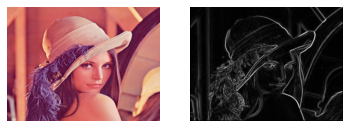

In [ ]:
# 自分が用意した画像をエッジ抽出
my_img, my_edge, my_gray = convert_image_to_matrix("../figure/lena.jpg", "sobel")
my_gt = show_image(my_img, my_edge, my_gray)

input_myimg, output_myimg = convert_pixel_value(my_img, my_gt)

In [ ]:
num_epoch=200

 ### MomentumSGDを利用した場合

loss: 0.011027831584215164
Time: 59.776413440704346


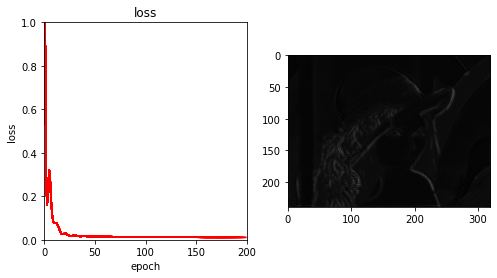

In [ ]:
model_momentumsgd = convolutional_regression_model(optimizer="momentum_sgd")

show_graph = ShowGraph(model_momentumsgd, num_epoch,input_myimg, optimizer="momentumsgd", is_batch=False)
model_momentumsgd.fit(input_myimg, output_myimg, batch_size=1, epochs=num_epoch, verbose=0, callbacks=[show_graph])
del show_graph

### RMSpropを利用した場合

loss: 0.011666557751595974
Time: 57.70145034790039


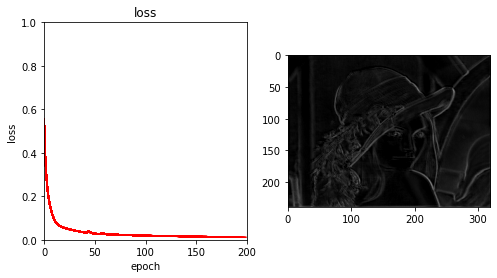

In [ ]:
model_rmsprop = convolutional_regression_model(optimizer="rmsprop")

show_graph = ShowGraph(model_rmsprop,num_epoch,input_myimg, optimizer="rmsprop", is_batch=False)
model_rmsprop.fit(input_myimg, output_myimg, batch_size=1, epochs=num_epoch, verbose=0, callbacks=[show_graph])
del show_graph

### Adamを利用した場合

loss: 0.02629539556801319
Time: 57.18331813812256


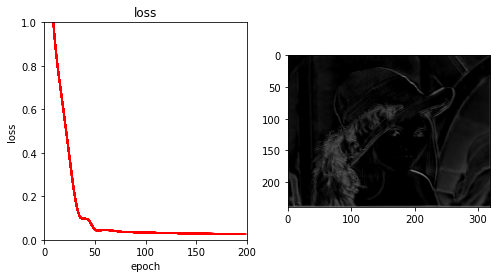

In [ ]:
model_adam = convolutional_regression_model(optimizer="adam")

show_graph = ShowGraph(model_adam,num_epoch,input_myimg, optimizer="adam", is_batch=False)
model_adam.fit(input_myimg, output_myimg, batch_size=1, epochs=num_epoch, verbose=0, callbacks=[show_graph])
del show_graph

### 課題2.2 課題2.1で最もlossが小さくなったoptimizerを利用して，Batch Normalization Layer を入れた場合と入れない場合で，結果を比較せよ．

### 最もlossが小さくなった手法は MomentumSGDだった．
### Batch Normalization Layerを導入した場合

loss: 0.0091853654012084
Time: 58.814401149749756


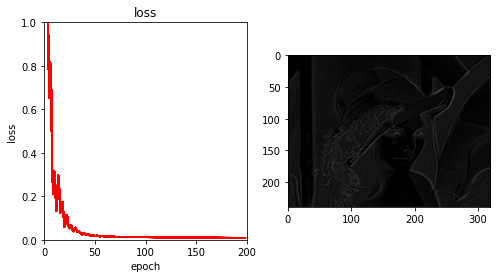

In [ ]:
model_momentumsgd_with_bn = convolutional_regression_model(optimizer="momentum_sgd", is_batch=True)

show_graph = ShowGraph(model_momentumsgd_with_bn,num_epoch,input_myimg, optimizer="momentumsgd", is_batch=True)
model_momentumsgd_with_bn.fit(input_myimg, output_myimg, batch_size=1, epochs=num_epoch, verbose=0, callbacks=[show_graph])
del show_graph